<a href="https://colab.research.google.com/github/monicastambuk/monicastambuk-IIC3633-2020/blob/master/Implicit_implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    644      0 --:--:-- --:--:-- --:--:--   644
100 1546k  100 1546k    0     0  1907k      0 --:--:-- --:--:-- --:--:-- 1907k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    777      0 --:--:-- --:--:-- --:--:--   776
100  385k  100  385k    0     0   588k      0 --:--:-- --:--:-- --:--:--  588k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    955      0 --:--:-- --:--:-- --:--:--   955
100  230k  100  230k    0     0   400k      0 --:--:-- --:--:-- --:--:--  225M


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 2.7MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420114 sha256=75d5eaacb4e5d823bf2d3c8f8d3cc091cd894abdd931b0b61958c6b1e709a4fe
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [13]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [14]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [15]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [16]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:**Consiste en actualizar vectores de usuarios e items de manera alterna; buscando con ello que la matriz de interacción que se genera por el producto punto entre ambos vectores (usuario/item), con la idea de que esté sea lo más semejante a la matriz original.

In [17]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [18]:
show_recommendations(model_als, user=77, n=10)

movieid
256     When the Cats Away (Chacun cherche son chat) (...
292                                       Rosewood (1997)
257                                   Men in Black (1997)
754                                     Red Corner (1997)
273                                           Heat (1995)
1012                                 Private Parts (1997)
567                     Wes Craven's New Nightmare (1994)
258                                        Contact (1997)
125                                     Phenomenon (1996)
595                                       Fan, The (1996)
Name: title, dtype: object

In [19]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.07101188123415758
ndcg: 0.3445635528330781


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [20]:
maprec, ndcg = evaluate_model(model_als, n=50)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.17936526819260892
ndcg: 0.6937212863705973


In [21]:
show_recommendations(model_als, user=88, n=50)

movieid
274                                      Sabrina (1995)
110                         Operation Dumbo Drop (1995)
236                                 Citizen Ruth (1996)
12                           Usual Suspects, The (1995)
286                         English Patient, The (1996)
722                                  Nine Months (1995)
189                             Grand Day Out, A (1992)
779                                    Drop Zone (1994)
268                                  Chasing Amy (1997)
108                Kids in the Hall: Brain Candy (1996)
402                                        Ghost (1990)
96                    Terminator 2: Judgment Day (1991)
273                                         Heat (1995)
484                          Maltese Falcon, The (1941)
178                                 12 Angry Men (1957)
254                               Batman & Robin (1997)
292                                     Rosewood (1997)
237                                Jerry

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.Explique con sus palabras la intuición del framework BPR. BPR identifica las recomendaciones como un ordenamiento dado que se pueda crear tuplas (u, i, j), donde se ordena al usuario según sus preferencias, transformando la matriz de items vista por el usuario en varios sub funciones de potenciales items que no han sido vistos por ese usuario, para así predecir las preferencias de esté.

In [22]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [23]:
show_recommendations(model_bpr, user=77, n=10)

movieid
299                                    Hoodlum (1997)
746                                Real Genius (1985)
257                               Men in Black (1997)
285                             Secrets & Lies (1996)
244                     Smilla's Sense of Snow (1997)
332                             Kiss the Girls (1997)
312    Midnight in the Garden of Good and Evil (1997)
327                                   Cop Land (1997)
325                                      Crash (1996)
303                                Ulee's Gold (1997)
Name: title, dtype: object

In [24]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                       Delicatessen (1991)
209                 This Is Spinal Tap (1984)
27                            Bad Boys (1995)
201                       Evil Dead II (1987)
264                              Mimic (1997)
81                Hudsucker Proxy, The (1994)
194                         Sting, The (1973)
422    Aladdin and the King of Thieves (1996)
95                             Aladdin (1992)
30                       Belle de jour (1967)
Name: title, dtype: object

In [25]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05376100573137919
ndcg: 0.34150076569678406


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

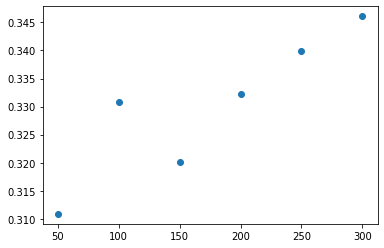

In [26]:
factors = [50, 100, 150, 200, 250, 300]

ndcgs = []
maps = []

for f in factors:
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=10, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)
  maps.append(maprec)
  ndcgs.append(ndcg)

import matplotlib.pyplot as plt 
plt.scatter(y=ndcgs, x=factors)








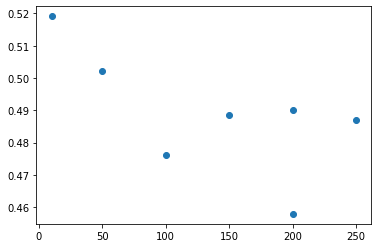

In [29]:
factors = [10, 50, 100, 150, 200, 200, 250]

ndcgs = []
maps = []

for f in factors:
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=20, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=20)
  maps.append(maprec)
  ndcgs.append(ndcg)

import matplotlib.pyplot as plt 
plt.scatter(y=ndcgs, x=factors)